In [2]:
#Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
from matplotlib import pyplot as plt
import glob
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce
import datetime
from IPython.display import display, HTML
from IPython.display import Markdown as md
import contextily

In [3]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
#Import full temperature record from 1/1/2008 to 2/1/2022
filepath = r'T:\sxin\JFA\Production Facility\Temperature\daily\*.csv'
files = glob.glob(filepath)
tempList = []
for file in files:
    wellName = file[50:]
    wellName = wellName.split('_daily')[0]    
    if wellName == 'USGS_hacienda':
        tempList.append(pd.read_csv(file, names=['Date', wellName+'_max', wellName+'_min', wellName+'_mean'], header=None))
    else:
        tempList.append(pd.read_csv(file, names=['Date', wellName], header=None))
        
for index, df in enumerate(tempList):
    df = df[1:]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    if index == 0:    
        dfAll = df
    else:
        dfAll = pd.merge(dfAll, df, left_index=True, right_index=True, how='outer')
        
cols = dfAll.columns        
dfAll[cols] = dfAll[cols].apply(pd.to_numeric, errors='coerce')

for col in dfAll[['USGS_hacienda_max','USGS_hacienda_min','USGS_hacienda_mean']]:
    dfAll[col] = dfAll[col] * (9/5) + 32

In [5]:
#Import monitor wells record
plotFilePath = r'T:\sxin\JFA\Production Facility\Site Selection\SCWA wells.xlsx'
dfPlot = pd.read_excel(plotFilePath, sheet_name ='Summary')

In [6]:
#Import collector wells record
plotFilePath2 = r'T:\sxin\JFA\Production Facility\Site Selection\Caissons.xlsx'
dfPlot2 = pd.read_excel(plotFilePath2)

#Convert collector DataFrame to GeoDataFrame
gdf_cw = gpd.GeoDataFrame(dfPlot2, geometry=gpd.points_from_xy(dfPlot2['LONGITUDE'], dfPlot2['LATITUDE'], crs='EPSG:4326'))

In [7]:
#Categorize monitoring wells by historical record data types (GWE, WQ, Temp)
dfPlotUpdate = dfPlot
dfPlotUpdate['Data Type'] = ''
for index, well in enumerate(dfPlot['Well Name']):
    label = ''
    if not (dfPlot['GWE Monitoring Period Start'].iloc[index]==' '):
        label += 'GWE.'
        if not (pd.isna(dfPlot['WQ Record Start'].iloc[index])):
            label += '+WQ.'
            if dfPlot['Temp. Record'].iloc[index]=='Y':
                label += '+Temp.'                
        elif dfPlot['Temp. Record'].iloc[index]=='Y':
                   label += '+Temp.'    
    elif not (pd.isna(dfPlot['WQ Record Start'].iloc[index])):
        label += 'WQ.'
        if dfPlot['Temp. Record'].iloc[index]=='Y':
            label += '+Temp.'            
    elif dfPlot['Temp. Record'].iloc[index]=='Y':
        label += '+Temp.'
    else:
        label += 'No Record'
    
    dfPlotUpdate.at[index, 'Data Type'] = label
    
dfPlotUpdatev2 = dfPlotUpdate[dfPlotUpdate['Data Type'] != 'No Record']

In [8]:
# All monitoring wells
# fig = go.Figure()

# fig.add_trace(go.Scattermapbox(
#         lat=dfPlot['Latitude'],
#         lon=dfPlot['Longitude'],
#         mode='markers+text',
#         marker=go.scattermapbox.Marker(size=6, color='rgb(255, 0, 0)', opacity=0.7),
#         name = 'MWs',
#         hoverinfo = 'text',
#         text=dfPlot['Well Name']))
# fig.add_trace(go.Scattermapbox(
#         lat=dfPlot2['LATITUDE'],
#         lon=dfPlot2['LONGITUDE'],
#         mode='markers+text',
#         marker=go.scattermapbox.Marker(size=8, color='blue', opacity=0.7),
#         name = 'Caissons',
#         hoverinfo = 'text',
#         text=dfPlot2['NAME'],
#         textposition = "bottom right"))
# fig.update_layout(
#     autosize=False,
#     title = 'Monitoring Wells Location Map',
#     width = 1000,
#     height = 800,
#     hovermode="x",
#     mapbox_style="open-street-map",
#     mapbox=dict(center=dict(lat=38.508,lon=-122.883), zoom=13)
# )

# fig.show()



# #Monitoring wells with historical record
# fig1 = go.Figure()    
# fig1 = px.scatter_mapbox(dfPlotUpdatev2, lon = dfPlotUpdatev2['Longitude'], lat = dfPlotUpdatev2['Latitude'], 
#                          color = dfPlotUpdatev2['Data Type'], hover_name = dfPlotUpdatev2['Well Name'], 
#                         hover_data={'Longitude':False, 'Latitude': False, 'Data Type': False})

# fig1.update_traces(go.Scattermapbox(marker=dict(size=10)))
# fig1.add_trace(go.Scattermapbox(
#         lat=dfPlot2['LATITUDE'],
#         lon=dfPlot2['LONGITUDE'],
#         mode='markers+text',
#         marker=dict(allowoverlap=True, size=15, color='black', opacity=0.3),
#         name = 'Caissons',
#         hoverinfo = 'text',
#         text=dfPlot2['NAME'],
#         textposition = "bottom right"))
# fig1.update_layout(
#     autosize=False,
#     title = 'Monitoring Wells W/Categorized Historical Record',
#     width = 1000,
#     height = 800,
#     hovermode="x",
#     mapbox_style="open-street-map",
#     mapbox=dict(accesstoken=mapbox_access_token,center=dict(lat=38.508,lon=-122.883), zoom=13)
# )

# fig1.show()


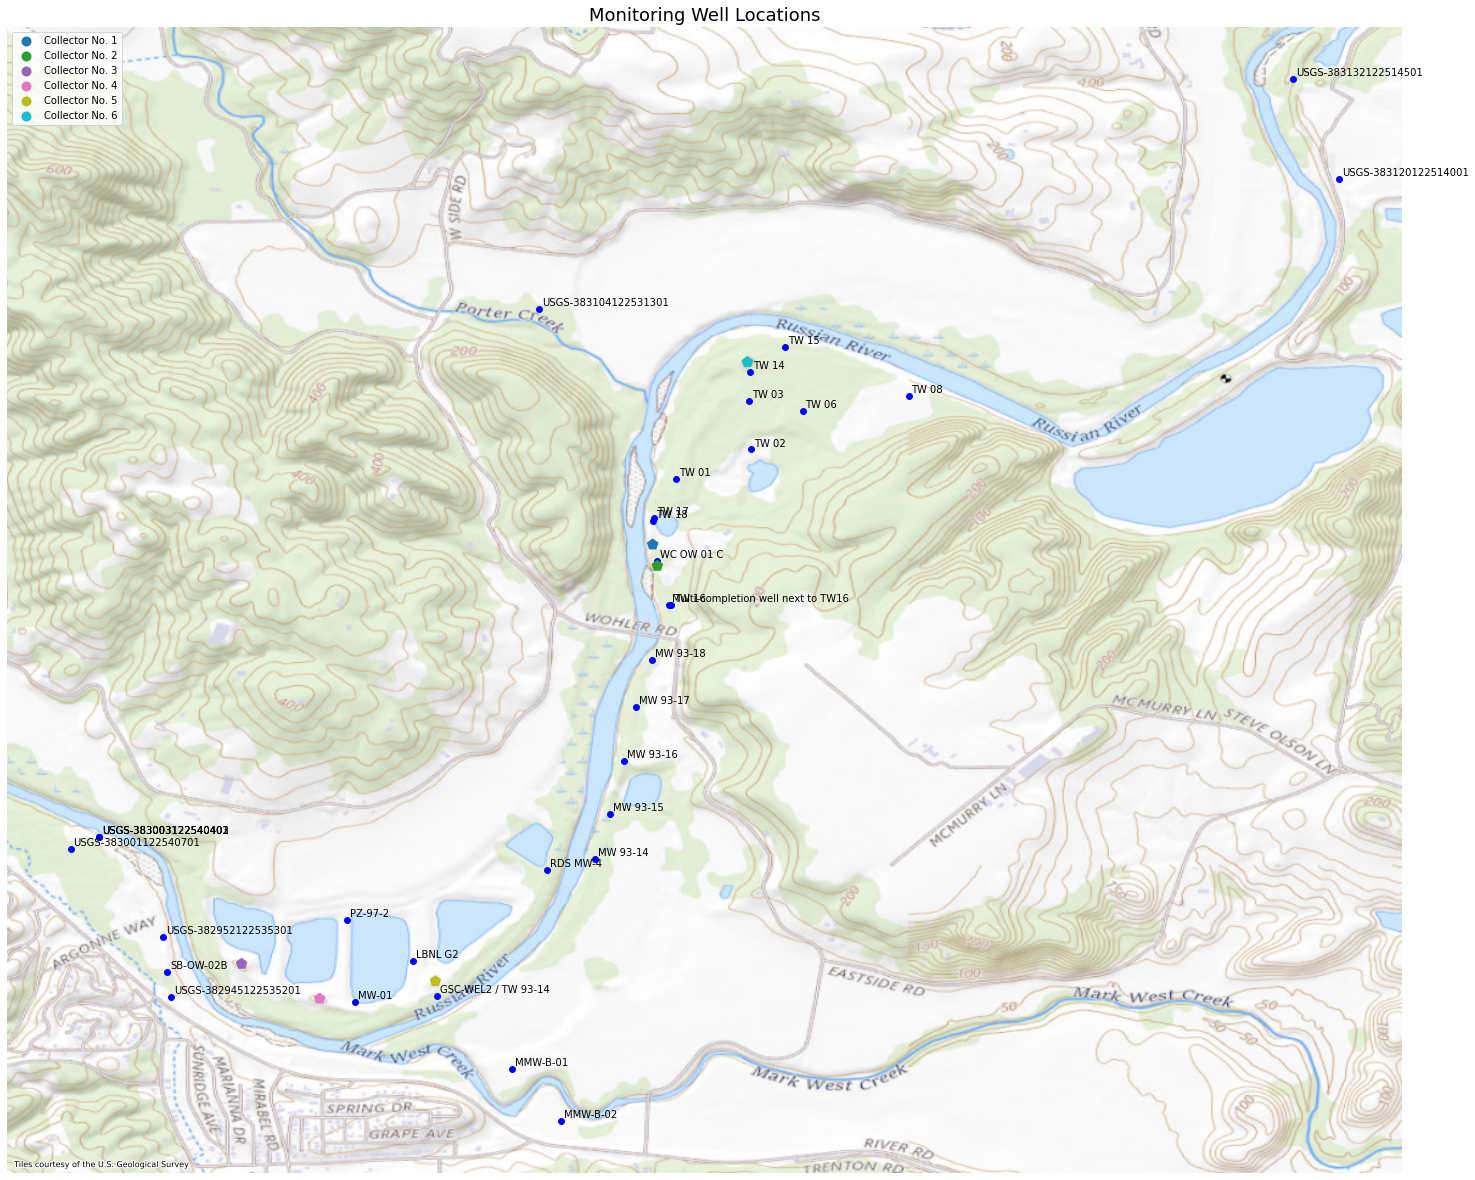

In [12]:
%%capture --no-display
#Convert to GeoDataFrame from DataFrame
gdf_mw = gpd.GeoDataFrame(dfPlot, geometry=gpd.points_from_xy(dfPlot['Longitude'], dfPlot['Latitude'], crs='EPSG:4326'))

#Create Map
fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize = (25,25))
gdf_mw.plot(ax=ax, color='blue', markersize = 35,column='Well Name')
gdf_cw.plot(ax=ax, markersize=120, marker='p', legend=True, column='NAME')
contextily.add_basemap(ax, crs=gdf_mw.crs.to_string(), source=contextily.providers.USGS.USTopo)
plt.axis('off')
plt.title('Monitoring Well Locations', fontsize=18)

for x, y, label in zip(gdf_mw.geometry.x, gdf_mw.geometry.y, gdf_mw['Well Name']):
    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')
#for x, y, label in zip(gdf_cw.geometry.x, gdf_cw.geometry.y, gdf_cw['NAME']):
#    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')

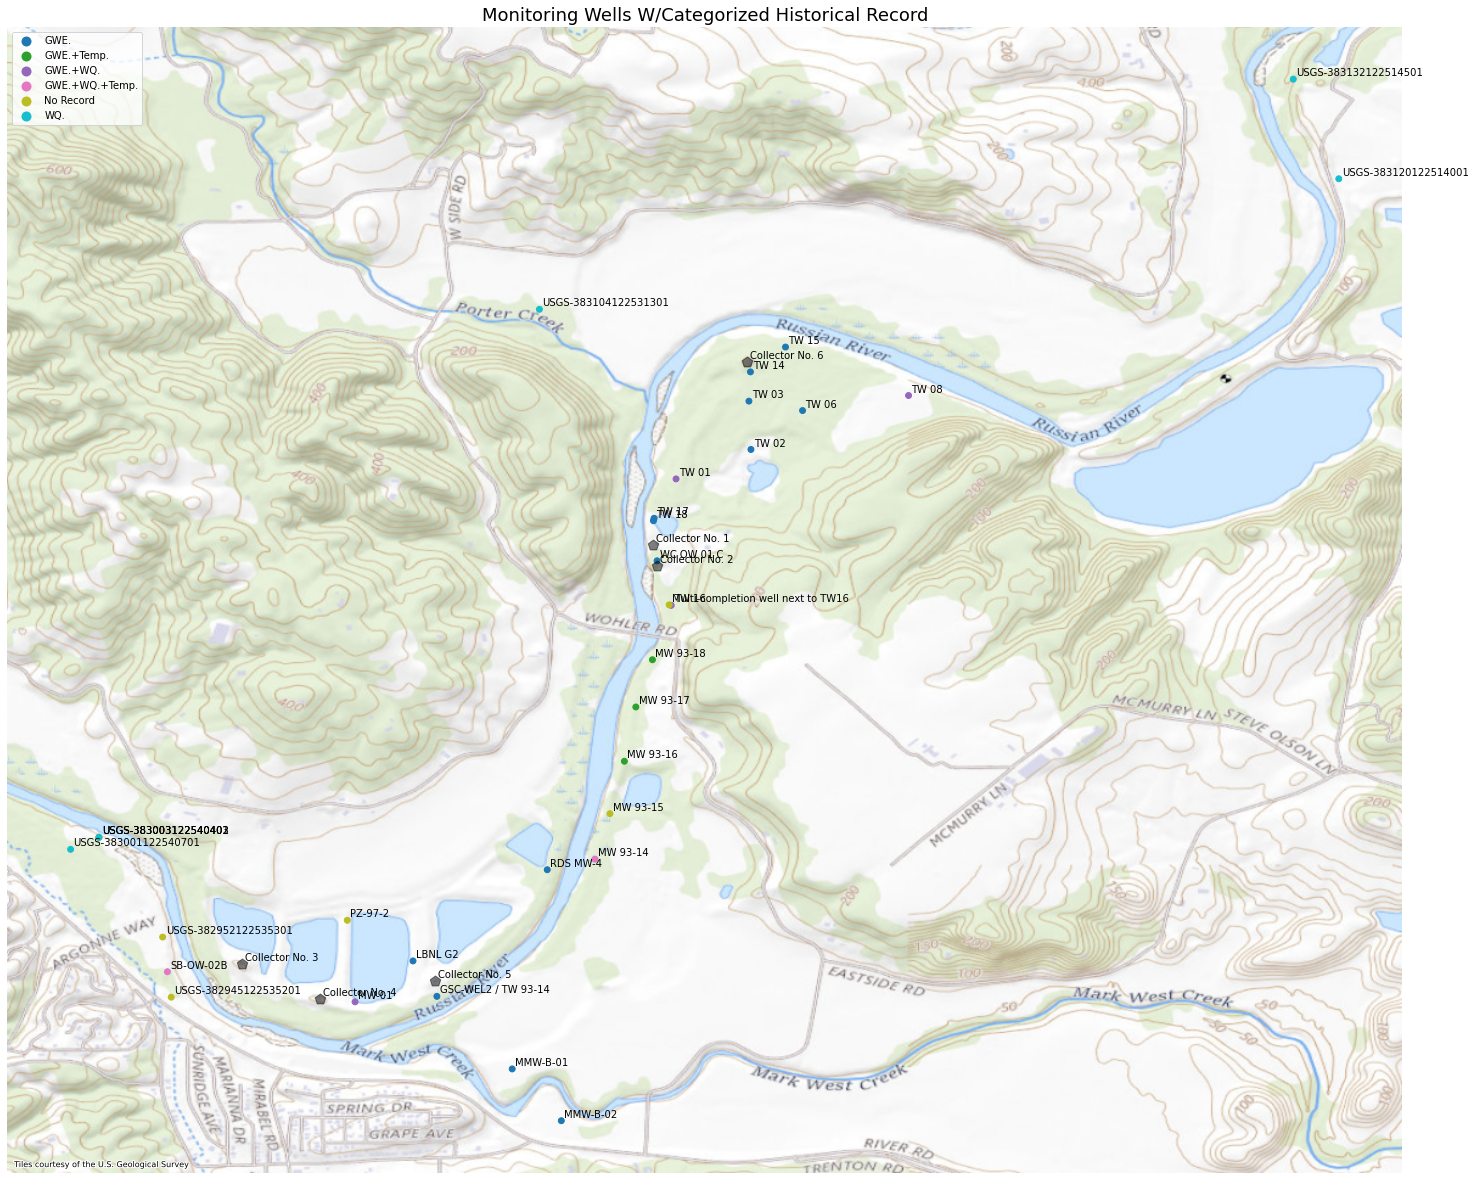

In [19]:
%%capture --no-display
#Convert to GeoDataFrame from DataFrame
gdf_mw = gpd.GeoDataFrame(dfPlotUpdate, geometry=gpd.points_from_xy(dfPlotUpdate['Longitude'], dfPlotUpdate['Latitude'], crs='EPSG:4326'))

#Create Map
fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize = (25,25))
gdf_mw.plot(ax=ax, markersize = 35,column='Data Type', legend=True)
gdf_cw.plot(ax=ax, markersize=120, marker='p', column='NAME', color='black',alpha=0.5, legend=True)
contextily.add_basemap(ax, crs=gdf_mw.crs.to_string(), source=contextily.providers.USGS.USTopo)
plt.axis('off')
plt.title('Monitoring Wells W/Categorized Historical Record', fontsize=18)

for x, y, label in zip(gdf_mw.geometry.x, gdf_mw.geometry.y, gdf_mw['Well Name']):
    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')
for x, y, label in zip(gdf_cw.geometry.x, gdf_cw.geometry.y, gdf_cw['NAME']):
    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')

In [45]:
# #Map of wells in Wohler pool area

# dfPlotUpdate_Wohler = dfPlotUpdate[dfPlotUpdate['Location'] == 'Wohler']

# fig2 = go.Figure()    
# fig2 = px.scatter_mapbox(dfPlotUpdate_Wohler, lon = dfPlotUpdate_Wohler['Longitude'], lat = dfPlotUpdate_Wohler['Latitude'], 
#                          color = dfPlotUpdate_Wohler['Data Type'], hover_name = dfPlotUpdate_Wohler['Well Name'], 
#                         hover_data={'Longitude':False, 'Latitude': False, 'Data Type': False})

# fig2.update_traces(go.Scattermapbox(marker=dict(size=10)))
# fig2.add_trace(go.Scattermapbox(
#         lat=dfPlot2['LATITUDE'],
#         lon=dfPlot2['LONGITUDE'],
#         mode='markers+text',
#         marker=dict(allowoverlap=True, size=15, color='black', opacity=0.3),
#         name = 'Caissons',
#         hoverinfo = 'text',
#         text=dfPlot2['NAME'],
#         textposition = "bottom right"))
# fig2.update_layout(
#     autosize=False,
#     title = 'Map of Monitoring Wells in Wohler Pool Area Only',
#     width = 1000,
#     height = 800,
#     hovermode="x",
#     mapbox_style="open-street-map",
#     mapbox=dict(accesstoken=mapbox_access_token,center=dict(lat=38.509,lon=-122.883), zoom=14)
# )

# fig2.show()

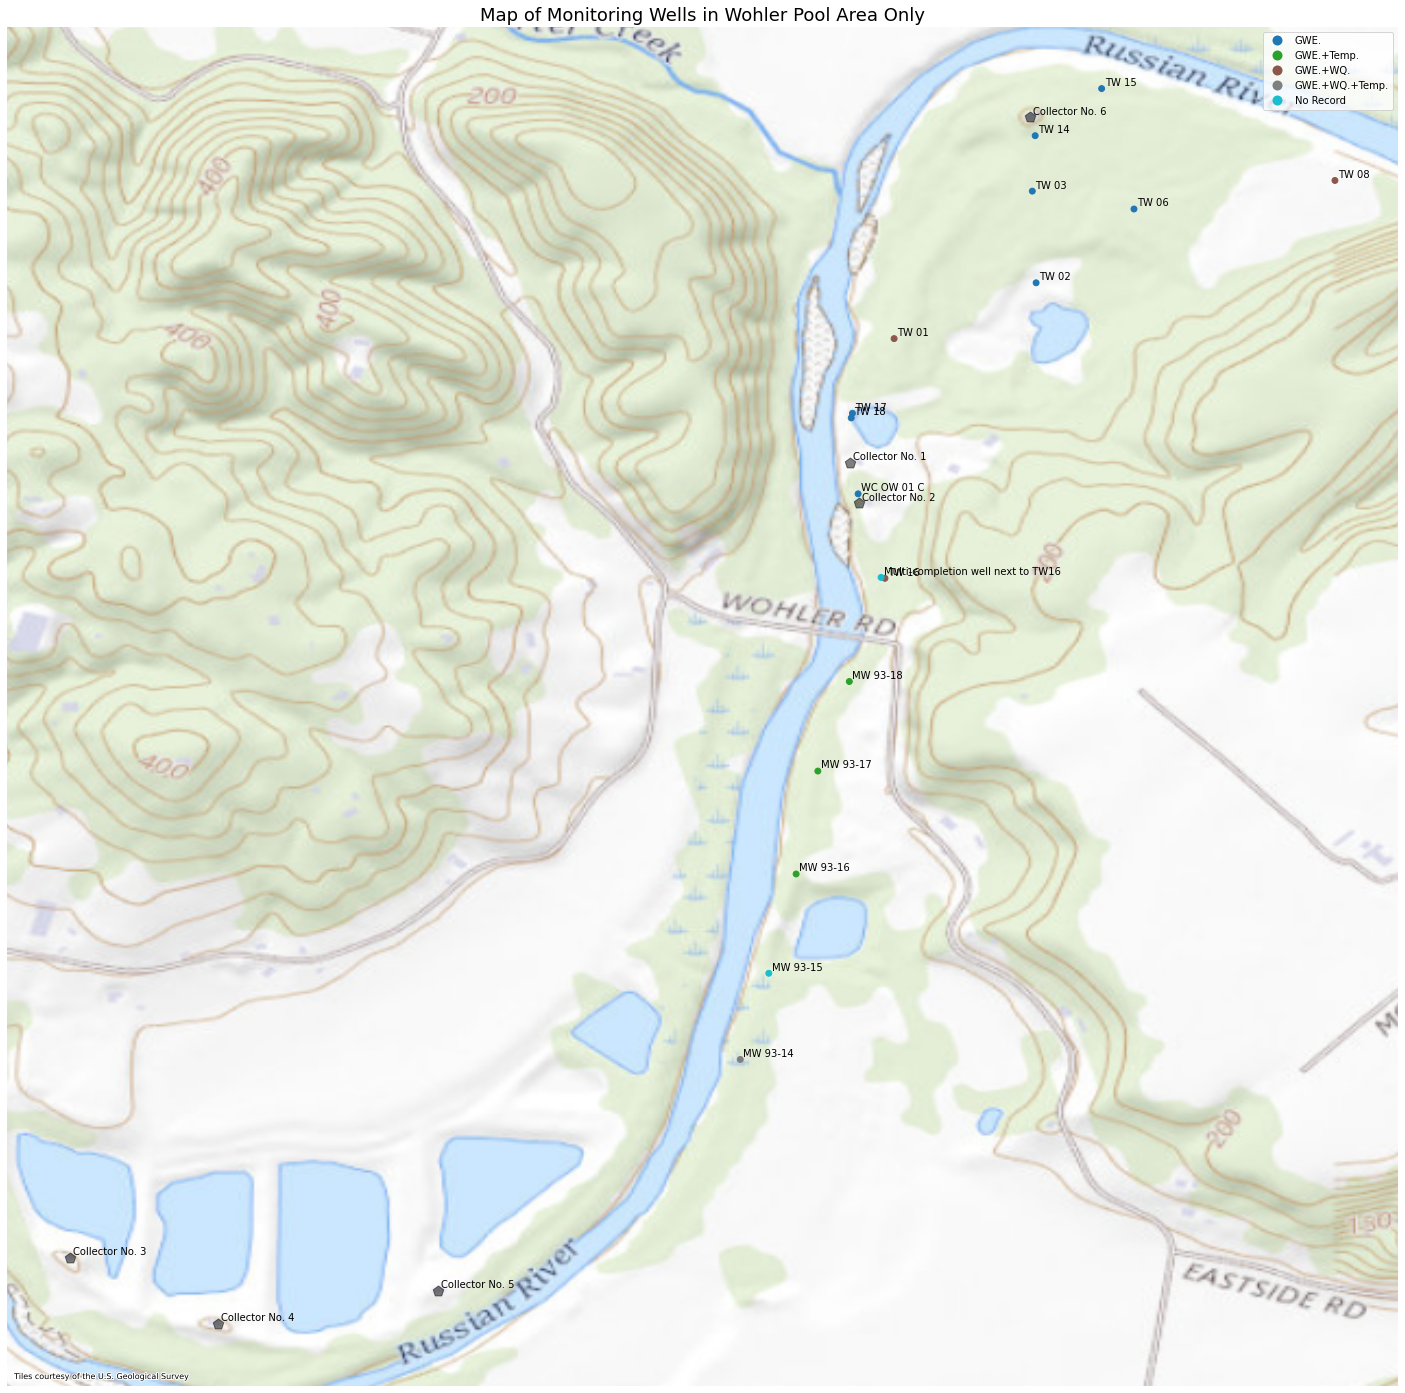

In [18]:
%%capture --no-display
#Map of wells in Wohler pool area

dfPlotUpdate_Wohler = dfPlotUpdate[dfPlotUpdate['Location'] == 'Wohler']

#Convert to GeoDataFrame from DataFrame
gdf_mw = gpd.GeoDataFrame(dfPlotUpdate_Wohler, geometry=gpd.points_from_xy(dfPlotUpdate_Wohler['Longitude'], dfPlotUpdate_Wohler['Latitude'], crs='EPSG:4326'))

#Create Map
fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize = (25,25))
gdf_mw.plot(ax=ax, markersize = 35,column='Data Type', legend=True)
gdf_cw.plot(ax=ax, markersize=120, marker='p', color='black',alpha=0.5, legend=True)
contextily.add_basemap(ax, crs=gdf_mw.crs.to_string(), source=contextily.providers.USGS.USTopo)
plt.axis('off')
plt.title('Map of Monitoring Wells in Wohler Pool Area Only', fontsize=18)

for x, y, label in zip(gdf_mw.geometry.x, gdf_mw.geometry.y, gdf_mw['Well Name']):
    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')
for x, y, label in zip(gdf_cw.geometry.x, gdf_cw.geometry.y, gdf_cw['NAME']):
    ax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')